<a href="https://colab.research.google.com/github/RandomAnass/Analysis-of-new-phenomena-in-deep-learning/blob/main/Fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

fashion_mnist = tf.keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


In [6]:

# Normalize the pixel values between 0 and 1
x_train = x_train / 255.0
x_test = x_test / 255.0

# Reshape the input data to add a channel dimension (needed for convolutional models)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)

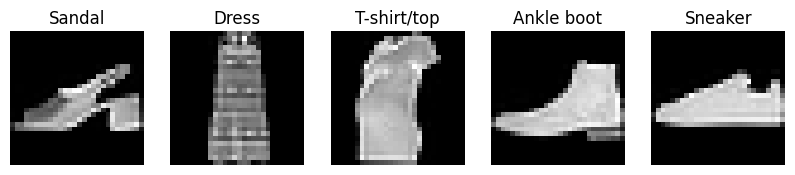

In [7]:
import matplotlib.pyplot as plt
import numpy as np
# Plot examples of images from the Fashion MNIST dataset
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Select random images from the test set
num_images = 5
random_indexes = np.random.choice(len(x_test), num_images, replace=False)
images = x_test[random_indexes]
labels = y_test[random_indexes]

# Plot the images
plt.figure(figsize=(10, 5))
for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(images[i].reshape(28, 28), cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis('off')

plt.show()

In [8]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 49.5 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [12]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ReLU, GlobalAveragePooling2D, Dense, Lambda, GlobalMaxPooling2D,Flatten
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescentTensorFlowV2
from tqdm import tqdm
import os
from art.utils import load_mnist
from tensorflow.keras import layers

In [11]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.list_physical_devices("GPU")


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
def circular_padding(x, padding_size):
    # Perform circular padding on the input tensor
    return tf.pad(x, [[0, 0], [padding_size, padding_size], [padding_size, padding_size], [0, 0]], mode='SYMMETRIC')

def simple_Conv(n_hidden, kernel_size=28, padding_size=-1):
    if padding_size == -1:
        padding_size = kernel_size // 2

    model = Sequential()
    model.add(Lambda(lambda x: circular_padding(x, padding_size), input_shape=(28, 28, 1)))
    model.add(Conv2D(n_hidden, kernel_size=kernel_size, padding='valid'))
    model.add(ReLU())
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10))

    return model

def simple_Conv_NL(n_hidden,kernel_size=28):
    """ no lambda """
    model = Sequential()
    model.add(Conv2D(n_hidden, kernel_size=kernel_size, padding='same', input_shape=(28, 28, 1), activation='relu'))
    model.add(GlobalAveragePooling2D())
    model.add(Dense(10))

    return model

def simple_FC(n_hidden):
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28)))
    model.add(Dense(n_hidden, activation="relu"))
    model.add(Dense(10))

    return model

def simple_Conv_max(n_hidden, kernel_size=28):
    model = Sequential()
    model.add(Conv2D(n_hidden, kernel_size=kernel_size, padding='same', input_shape=(28, 28, 1), activation='relu'))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(10))

    return model

def simple_Conv_max(n_hidden, kernel_size=28):
    model = Sequential()
    model.add(Conv2D(n_hidden, kernel_size=kernel_size, padding='same', input_shape=(28, 28, 1), activation='relu'))
    model.add(GlobalMaxPooling2D())
    model.add(Dense(10))

    return model

def simple_Conv_2():
    model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    return model

def simple_FC_2():
    model = tf.keras.Sequential([
        layers.Flatten(input_shape=(28, 28)),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])

    return model


def simple__RNN():

    model = tf.keras.Sequential([
        layers.Reshape((28, 28), input_shape=(28, 28, 1)),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(128),
        layers.Dense(10, activation='softmax')
    ])

    return model

model_names = {'simple_FC':simple_FC, 'simple_Conv':simple_Conv, 'simple_Conv_NL':simple_Conv_NL, 
               'simple_Conv_max':simple_Conv_max, 'simple__RNN':simple__RNN , 'simple_FC_2':simple_FC_2, 'simple_Conv_2':simple_Conv_2}

(array([1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000., 1000.,
        1000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

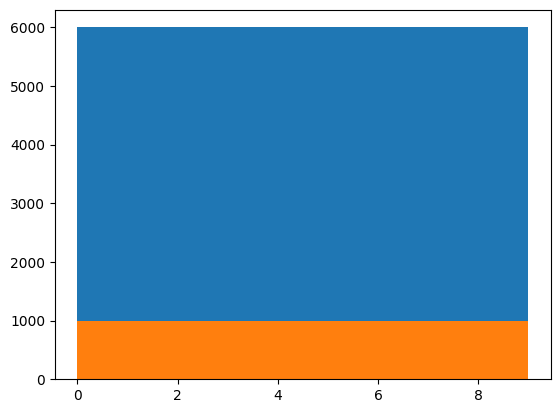

In [14]:
import matplotlib.pyplot as plt
plt.hist(np.argmax(y_train, axis=1))
plt.hist(np.argmax(y_test, axis=1))

In [15]:
padding_sizes = [0, 2, 4, 6, 8, 10, 12, 14]
#padding_size=-1
padding_size = 0 #padding_sizes[3]
n_hidden = 1024 #1000
kernel_size=28

In [16]:
import numpy as np
import tensorflow as tf
from art.estimators.classification import TensorFlowV2Classifier

def train_step(model, optimizer, loss_object, images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def create_art_classifier(model_creator, x_train, y_train, batch_size=200, nb_epochs=30, **kwargs): # nb_epochs=200
    # Create the CNN model and optimizer
    model = model_creator(**kwargs)
    optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=0.1, momentum=0.9, decay=5e-4)
    loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    model.compile(optimizer=optimizer, loss=loss_object, metrics=['accuracy'])


    # Create the ART classifier
    classifier = TensorFlowV2Classifier(
        model=model,
        loss_object=loss_object,
        train_step=train_step,
        nb_classes=10,
        input_shape=(28, 28, 1),
        clip_values=(0, 1),
    )
    # Custom training loop
    train_acc = []
    test_acc = []
    for epoch in range(nb_epochs):
        print("Epoch {}/{}".format(epoch + 1, nb_epochs))
        epoch_loss = []
        for batch in range(0, len(x_train), batch_size):
            batch_images = x_train[batch:batch + batch_size]
            batch_labels = y_train[batch:batch + batch_size]
            loss = train_step(model, optimizer, loss_object, batch_images, batch_labels)
            epoch_loss.append(loss)
        #print(epoch_loss)
        avg_loss = np.mean(epoch_loss)
        print("Average loss: {:.4f}".format(avg_loss))

        # Perform predictions and evaluate accuracy on examples
        predictions = classifier.predict(x_test)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        test_acc.append(accuracy)
        print("Accuracy on test examples: {:.2%}".format(accuracy))

        predictions = classifier.predict(x_train)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
        train_acc.append(accuracy)
        print("Accuracy on train examples: {:.2%}".format(accuracy))

    return [classifier, test_acc, train_acc]


In [17]:
models = [
    create_art_classifier(model_creator=simple_FC, x_train=x_train, y_train=y_train, n_hidden=n_hidden),
    create_art_classifier(model_creator=simple_Conv, x_train=x_train, y_train=y_train, n_hidden=n_hidden, kernel_size=kernel_size, padding_size=padding_size),
    create_art_classifier(model_creator=simple_Conv_NL, x_train=x_train, y_train=y_train, n_hidden=n_hidden, kernel_size=kernel_size),
    create_art_classifier(model_creator=simple_Conv_max, x_train=x_train, y_train=y_train, n_hidden=n_hidden, kernel_size=kernel_size),
    create_art_classifier(model_creator=simple__RNN, x_train=x_train, y_train=y_train),
    create_art_classifier(model_creator=simple_FC_2, x_train=x_train, y_train=y_train),
    create_art_classifier(model_creator=simple_Conv_2, x_train=x_train, y_train=y_train)
]


Epoch 1/30
Average loss: 0.5185
Accuracy on test examples: 85.14%
Accuracy on train examples: 86.28%
Epoch 2/30
Average loss: 0.3807
Accuracy on test examples: 85.12%
Accuracy on train examples: 86.68%
Epoch 3/30
Average loss: 0.3382
Accuracy on test examples: 85.74%
Accuracy on train examples: 87.55%
Epoch 4/30
Average loss: 0.3120
Accuracy on test examples: 86.62%
Accuracy on train examples: 88.44%
Epoch 5/30
Average loss: 0.2935
Accuracy on test examples: 86.90%
Accuracy on train examples: 88.96%
Epoch 6/30
Average loss: 0.2778
Accuracy on test examples: 87.61%
Accuracy on train examples: 89.75%
Epoch 7/30
Average loss: 0.2655
Accuracy on test examples: 87.61%
Accuracy on train examples: 90.09%
Epoch 8/30
Average loss: 0.2526
Accuracy on test examples: 87.71%
Accuracy on train examples: 90.22%
Epoch 9/30
Average loss: 0.2423
Accuracy on test examples: 87.85%
Accuracy on train examples: 90.84%
Epoch 10/30
Average loss: 0.2333
Accuracy on test examples: 87.90%
Accuracy on train exampl

/usr/local/lib/python3.10/dist-packages/keras/backend.py:5561: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Average loss: 0.7658
Accuracy on test examples: 81.64%
Accuracy on train examples: 82.13%
Epoch 2/30
Average loss: 0.4460
Accuracy on test examples: 83.55%
Accuracy on train examples: 84.55%
Epoch 3/30
Average loss: 0.3884
Accuracy on test examples: 85.39%
Accuracy on train examples: 86.22%
Epoch 4/30
Average loss: 0.3554
Accuracy on test examples: 86.06%
Accuracy on train examples: 87.16%
Epoch 5/30
Average loss: 0.3311
Accuracy on test examples: 86.71%
Accuracy on train examples: 88.09%
Epoch 6/30
Average loss: 0.3117
Accuracy on test examples: 87.12%
Accuracy on train examples: 88.90%
Epoch 7/30
Average loss: 0.2969
Accuracy on test examples: 87.59%
Accuracy on train examples: 89.61%
Epoch 8/30
Average loss: 0.2843
Accuracy on test examples: 87.90%
Accuracy on train examples: 89.95%
Epoch 9/30
Average loss: 0.2726
Accuracy on test examples: 87.78%
Accuracy on train examples: 90.01%
Epoch 10/30
Average loss: 0.2627
Accuracy on test examples: 87.86%
Accuracy on train examples: 90.11%


In [ ]:
!mkdir -p saved_fashion_models

In [ ]:
for i, model in enumerate(models):
    model_name = f'saved_fashion_models/model_{i}.h5'
    model[0].model.save(model_name)

In [ ]:
array_models = np.array(models)
acc_array = array_models[:, [1,2]]
import pickle

# Save the models list to a file
with open('saved_fashion_models/acc_array.pkl', 'wb') as file:
    pickle.dump(acc_array, file)

In [ ]:
# Save the models list to a file
with open('saved_fashion_models/full_np.pkl', 'wb') as file:
    pickle.dump(array_models, file)

In [ ]:
!zip -r /content/saved_fashion_models.zip /content/saved_fashion_models

In [ ]:
from google.colab import files
files.download("/content/saved_fashion_models.zip")

In [ ]:
# Plot the training and validation accuracy for each model
plt.figure()
for model, (_, test_acc, train_acc) in zip(models, model_names):
    plt.plot(train_acc, label=model)
    plt.plot(test_acc, label=model)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
# Enable GPU acceleration for ART attacks
from art.config import ART_NUMPY_DTYPE
os.environ["ART_NUMPY_DTYPE"] = str(ART_NUMPY_DTYPE)

# Define the attack parameters
attack_params = [[np.inf, [0.05, 0.1,  0.15, 0.2, 0.25, 0.3]],[2, [0.5, 1, 1.5,  2.5, 3]]]


In [ ]:
for model, model_name in zip(models, model_names):
    classifier = model[0]
    # Iterate over the attack parameters and generate adversarial examples
    for norm, epsilons in attack_params:
        for epsilon in epsilons:
            if norm == 2:
                attack = FastGradientMethod(estimator=classifier, eps=epsilon, norm=norm)
            else:
                attack = ProjectedGradientDescentTensorFlowV2(estimator=classifier, eps=epsilon, norm=norm)

            attack_name = attack.__class__.__name__
            #model_name = "simple_Conv_28_10_1000"

            adv_correct = 0
            adv_loss = 0
            total = 0
            x_train_attack = []
            y_train_attack = []
            x_test_attack = []
            y_test_attack = []

            x_train_attack = attack.generate(x=x_train[:3000])
            y_train_attack = np.copy(y_train[:3000])

            x_test_attack = attack.generate(x=x_test[:3000])
            y_test_attack = np.copy(y_test[:3000])

            x_train_attack = np.array(x_train_attack)
            y_train_attack = np.array(y_train_attack)
            x_test_attack = np.array(x_test_attack)
            y_test_attack = np.array(y_test_attack)

            save_dir = "adversarial_fashion_data"
            os.makedirs(save_dir, exist_ok=True)
            np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_train.npz"),
                    x_train_attack=x_train_attack, y_train_attack=y_train_attack)
            np.savez(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}_test.npz"),
                    x_test_attack=x_test_attack, y_test_attack=y_test_attack)

            print(os.path.join(save_dir, f"{model_name}_{attack_name}_{epsilon}"))

            for x, y in tqdm(zip(x_test_attack, y_test_attack), total=len(y_test_attack),
                            desc="Evaluating Adversarial Examples"):
                predictions_adv = np.argmax(classifier.predict(np.expand_dims(x, axis=0)), axis=1)
                adv_correct += (predictions_adv == y).sum()
                total += 1

            _, adv_loss = classifier.model.evaluate(x_test_attack, y_test_attack, verbose=0)
            accuracy = adv_correct / total
            print("Accuracy on adversarial test examples (L_{:.0f}, eps={:.2f}): {:.2f}%. Loss: {:.2f}".format(
                norm, epsilon, accuracy * 100, adv_loss))

In [ ]:
!zip -r /content/adversarial_fashion_data.zip /content/adversarial_fashion_data

In [ ]:
from google.colab import files
files.download("/content/adversaadversarial_fashion_datarial_data.zip")

In [ ]:
import matplotlib.pyplot as plt

# Step 1: Load the attack data
attack_data = {}
#attack_params = [[np.inf, [0.05, 0.1,  0.15, 0.2, 0.25, 0.3]],[2, [0.5, 1, 1.5,  2.5, 3]]]
for model_name, model in zip(model_names,models):
    for norm, epsilons in attack_params:
        for epsilon in epsilons:
            for data_type in ["train", "test"]:
                if norm == np.inf:
                    attack_name = "ProjectedGradientDescentTensorFlowV2"
                else:
                    attack_name = "FastGradientMethod"
                file_name = f"/content/adversarial_fashion_data/{model_name}_{attack_name}_{epsilon}_{data_type}.npz"  # Modify the file name pattern as per your data
                attack_data[(model_name, norm, epsilon,data_type)] = (model,np.load(file_name))


In [ ]:
norms = [attack_params[0][0], 2]
epsilons = {
    attack_params[0][0]: attack_params[0][1],
    attack_params[1][0]: attack_params[1][1]
}

In [ ]:
norms

In [ ]:
epsilons

In [ ]:
model_names.keys()

In [ ]:

# DO NOT USE MODELS
models = ['simple_Conv_max', 'simple_Conv_NL', 'simple_Conv', 'simple_FC']

# Create a dictionary to store the accuracy for each norm and model
accuracy_data = {norm: {model: [] for model in models} for norm in norms}
for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    if data_type == "test":
        model = model[0]
        predictions = model.predict(x_test)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        accuracy_data[norm][model_name].append((0, accuracy))
    else:
        continue

In [ ]:
for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    if data_type == "test":
        model = model[0]
        predictions = model.predict(data[f'x_{data_type}_attack'])
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])
        accuracy_data[norm][model_name].append((epsilon, accuracy))
    else:
        continue

In [ ]:
for norm in norms:
    plt.figure()
    for model_name in models:
        accuracies = accuracy_data[norm][model_name]
        eps, accs = zip(*accuracies)
        plt.plot(eps, accs, marker='o', label=model_name)
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy on Attack Data (Norm={norm})")
    plt.legend()
    plt.show()

In [ ]:
def evaluate_shift_invariance(model, x_test, y_test, shifts):
    model = model[0]
    accuracies = []
    for shift in tqdm(shifts):
        shifted_images = shift_images(x_test, shift)
        predictions = model.predict(shifted_images)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        accuracies.append(accuracy)
    return accuracies
shifts = range(10,-11,-1)
results = []
for model in tqdm(models):
    
    accuracy = evaluate_shift_invariance(model, x_test, y_test, shifts)
    results.append(accuracy)

In [ ]:
accuracy_data = {norm: {model: [] for model in models} for norm in norms}
for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    if data_type == "train":
        model = model[0]
        predictions = model.predict(x_train)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_train, axis=1)) / len(y_train)
        accuracy_data[norm][model_name].append((0, accuracy))
    else:
        continue

In [ ]:
for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
    if data_type == "train":
        model = model[0]
        predictions = model.predict(data[f'x_{data_type}_attack'])
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(data[f'y_{data_type}_attack'], axis=1)) / len(data[f'y_{data_type}_attack'])
        accuracy_data[norm][model_name].append((epsilon, accuracy))
    else:
        continue

In [ ]:
for norm in norms:
    plt.figure()
    for model_name in models:
        accuracies = accuracy_data[norm][model_name]
        eps, accs = zip(*accuracies)
        plt.plot(eps, accs, marker='o', label=model_name)
    plt.xlabel('Epsilon')
    plt.ylabel('Accuracy')
    plt.title(f"Accuracy on Attack Data (Norm={norm})")
    plt.legend()
    plt.show()


In [ ]:
#model_name_ = "simple_Conv"
norm_ = np.inf
epsilon_ = 0.15
data_type_ = "test"
accuracy_data = {model_name: {model: [] for model in models} for model_name in model_names.keys()}
adversarial_data_x = {}
adversarial_data_y = {}
for original_model in model_names:
    for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
        if (model_name, norm, epsilon, data_type) == (original_model, norm_, epsilon_, data_type_):
            adversarial_data_x[original_model] = data[f'x_{data_type}_attack']
            adversarial_data_y[original_model] = data[f'y_{data_type}_attack']
        else:
            continue
for original_model in model_names:
    for (model_name, norm, epsilon, data_type), (model, data) in attack_data.items():
        if data_type == data_type_ and epsilon == epsilon_ and norm == norm_:
            model = model[0]
            predictions = model.predict(adversarial_data_x[original_model])
            accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(adversarial_data_y[original_model], axis=1)) / len(adversarial_data_y[original_model])
            accuracy_data[original_model][model_name].append((norm,epsilon,accuracy))
        else:
            continue

In [ ]:
import matplotlib.pyplot as plt

for model_name, model_data in accuracy_data.items():
    fig, ax = plt.subplots()

    models = list(model_data.keys())
    accuracies = [item[0][2] for item in model_data.values()]

    ax.bar(models, accuracies)
    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy on Adversarial Data - Model: {model_name}')

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)

    # Show the plot
    plt.show()

In [ ]:
import matplotlib.pyplot as plt

def shift_images(images, shift, axis=0):
    shifted_images = np.roll(images, shift, axis=axis)
    return shifted_images

def evaluate_shift_invariance(model, x_test, y_test, shifts, axis=0):
    accuracies = []
    for shift in tqdm(shifts):
        shifted_images = shift_images(x_test, shift, axis=axis)
        predictions = model.predict(shifted_images)
        accuracy = np.sum(np.argmax(predictions, axis=1) == np.argmax(y_test, axis=1)) / len(y_test)
        accuracies.append(accuracy)
    return accuracies

shifts = range(10, -11, -1)
results = []

# TO DO
model_names = #['simple_FC', 'simple_Conv', 'simple_Conv_NL', 'simple_Conv_max']

for model, model_name in zip(models, model_names):
    model = model[0]
    accuracy_axis0 = evaluate_shift_invariance(model, x_test, y_test, shifts, axis=0)
    accuracy_axis1 = evaluate_shift_invariance(model, x_test, y_test, shifts, axis=1)
    results.append((model_name, accuracy_axis0, accuracy_axis1))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 10))

for model_name, accuracy_axis0, accuracy_axis1 in results:
    axes[0].plot(shifts, accuracy_axis0, label=model_name)
    axes[1].plot(shifts, accuracy_axis1, label=model_name)

axes[0].set_xlabel('Shift')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].set_title('Shift Invariance Evaluation (Axis 0)')

axes[1].set_xlabel('Shift')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Shift Invariance Evaluation (Axis 1)')

plt.tight_layout()
plt.show()

results_abs = []
for model_k in range(len(results)):
    shifts_abs = []
    results_abs_k = []
    for k in range(len(shifts)//2+1):
        shifts_abs.append(shifts[-k-1])
        results_abs_k.append((results[model_k][1][k] + results[model_k][1][-k-1]) / 2)
    results_abs.append((results[model_k][0], results_abs_k))
    
fig, ax = plt.subplots(figsize=(8, 6))

for model_name, accuracy in results_abs:
    ax.plot(shifts_abs, accuracy, label=model_name)

ax.set_xlabel('Shift')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Shift Invariance Evaluation (Symmetric Shifts)')

plt.tight_layout()
plt.show()